# Movie Type Analysis

## Overview

Virtucon has decided to enter the movie production business. The company needs to gain knowledge about which type of film does best at the box office.  We also tried to shed some light on less obvious area of the movie production process to give our studio a helping had in success.

To answer these queries we've gather data from 5 data sets with over 70K movies. We've focused on 1100, for which all data was available. These movies were produced from 2010 to 2018 and covered 29 genres.

Our analysis shows that the most profitable movies are of the genre Action and Adventure, with sub genres of Science Fition & Fantasy, or Mystery and Suspence. An honarable metion should go to the genre Animation, Comedy, Kids & Family which landed 3 films in the top 15. An analysis of movie runtimes show that movies which run 120 minutes have the highest audience ratings.

## Business Problem

Virtucon wants to produce movies but doesn't know which kind of movie does best at the box office. We've analyzed movie reviews, production costs, proffits, and even critics reviews to provide answers.

## Data

We used five data sets from four sources for our analysis. The Box Office Mojo dataset contains several sections reporting box office receipts by time period and area. The IMDB dataset inludes movies, TV and entertainment programs and cast and crew members. Rotten Tomato provded two datasets; movie data and critics' review data. Lastly we use The Numbers Movie Budget and Financial Performance Records dataset.


### Data Cleaning and Preparation
***

In [1]:
# Import the necessary modules

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3

pd.set_option('display.max_columns', 50)
pd.options.mode.copy_on_write = True

### Import all data sets to Pandas

In [2]:
# Connect to SQLite database
conn = sqlite3.connect('zippedData/im.db')
cursor = conn.cursor()

In [3]:
# Select the columns we are interested in and create a DataFrame
# from the movie_basics and movie_ratings tables

q = """
SELECT mb.movie_id, mb.primary_title, mb.start_year, mb.runtime_minutes, mb.genres,
       mr.averagerating, mr.numvotes
FROM movie_basics as mb
LEFT JOIN movie_ratings AS mr ON mb.movie_id = mr.movie_id;
"""
movie_df = pd.read_sql(q, conn)

In [4]:
# Read in the remaining CSV files into DataFrames
# Note: The thousands parameter is used to convert strings with commas into integers

bom_df = pd.read_csv("zippedData/bom.movie_gross.csv", thousands=',')
tn_df = pd.read_csv('zippedData/tn.movie_budgets.csv')
rm_df = pd.read_csv('zippedData/rotten_tomatoes_movies.csv')
rr_df = pd.read_csv('zippedData/rotten_tomatoes_critic_reviews.csv')

### Data Cleaning

In [5]:
# This data is very messy. Drop any duplicates in the DataFrames

movie_df = movie_df.drop_duplicates()
bom_df = bom_df.drop_duplicates()

In [6]:
# Drop the few rows where there is obviously error in year

movie_df = movie_df[movie_df['start_year'] <= 2026]

In [7]:
# Drop columns that are not needed in the DataFrame

rm_df.drop(['directors', 'authors', 'actors', 'streaming_release_date','tomatometer_top_critics_count', 
            'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count', 
            'tomatometer_rotten_critics_count', 'tomatometer_rotten_critics_count', 'tomatometer_count'], axis=1, inplace=True)

In [8]:
# These values are strings but we need them to be integers for analysis

tn_df['domestic_gross'] = tn_df['domestic_gross'].astype(str)
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].astype(str)
tn_df['production_budget'] = tn_df['production_budget'].astype(str)

tn_df['domestic_gross'] = tn_df['domestic_gross'].str.replace('[$,]', '', regex=True)
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].str.replace('[$,]', '', regex=True)
tn_df['production_budget'] = tn_df['production_budget'].str.replace('[$,]', '', regex=True)

tn_df['domestic_gross'] = pd.to_numeric(tn_df['domestic_gross'])
tn_df['worldwide_gross'] = pd.to_numeric(tn_df['worldwide_gross'])
tn_df['production_budget'] = pd.to_numeric(tn_df['production_budget'])

In [9]:
# Drop NAs
rr_df = rr_df.replace(to_replace='NaN', value=np.nan)
rr_df = rr_df.replace(to_replace='nan', value=np.nan)
rr_df = rr_df.dropna(subset=['review_date'])

In [10]:
rr_df['review_score'] = rr_df['review_score'].astype(str)

## Methods

The biggest hurdle in this project was the poor quality of the data. Each of the five datasets was quite disorganized, so we had to spend extra time cleaning them up. Since each dataset contained important information, we decided to combine them into one large set. During this process, we removed any duplicate or unnecessary information. Next, we figured out the profit for each film by subtracting its production costs from its total earnings. We then ranked the movies by profit within each genre to identify the most profitable genres. To figure out the ideal movie length, we looked at user ratings and calculated the average runtime of the highest-rated movies. Finally, finding the publication with the best reviews was tricky because different publications used different scoring systems. We first converted all the review scores to a common scale. Once the scores were consistent, we could calculate the average review score for each publication.

### Data Processing

In [11]:
# Merge the Box Office Movies and IMDB into one DataFrame

bom_movie_rt = pd.merge(bom_df, rm_df, left_on='title', right_on='movie_title', how='inner')
bom_movie_rt = bom_movie_rt.drop_duplicates(subset=['title', 'year'], keep='first')

In [12]:
# Create feature column for worldwide_profit

tn_df['domestic_profit'] = tn_df['domestic_gross'] - tn_df['production_budget']
tn_df['worldwide_profit'] = tn_df['worldwide_gross'] - tn_df['production_budget']

In [13]:
# Merge our main dataset with The Numbers dataset

bmrt_df = pd.merge(bom_movie_rt, tn_df, left_on='title', right_on='movie', how='inner')

In [14]:
# Drop more redundant columns

bmrt_df.drop(['studio', 'movie_title', 'original_release_date', 
            'production_company', 'release_date', 'movie', 'domestic_gross_x'], axis=1, inplace=True)

In [15]:
#bmrt_sorted = bmrt_df.sort_values(by=['worldwide_profit'], ascending=[False])
#bmrt_sorted[0:15] 

In [16]:
# Group by genres and calculate the average worldwide profit
# and sort the results in descending order

average_genre_profit = bmrt_df.groupby('genres')['worldwide_profit'].mean()
average_genre_profit = average_genre_profit.reset_index()
average_genre_profit = average_genre_profit.sort_values(by='worldwide_profit', ascending=False)
average_genre_profit['worldwide_profit'] = average_genre_profit['worldwide_profit'].map('${:,.2f}'.format)
average_genre_profit

,genres,worldwide_profit
7,"Action & Adventure, Animation, Drama, Kids & F...","$671,133,378.00"
86,"Classics, Comedy, Drama, Romance","$662,457,969.00"
69,"Animation, Comedy, Musical & Performing Arts","$559,454,789.00"
166,Romance,"$530,998,101.00"
61,Animation,"$529,438,211.00"
...,...,...
14,"Action & Adventure, Art House & International,...","$-31,007,708.00"
17,"Action & Adventure, Art House & International,...","$-33,485,675.00"
37,"Action & Adventure, Drama, Horror, Western","$-35,977,304.00"
6,"Action & Adventure, Animation, Comedy, Science...","$-38,146,816.00"


In [17]:
# Group by audience rating and show average runtime for that rating.

average_rating_runtime = bmrt_df.groupby('audience_rating')['runtime'].mean()
average_rating_runtime = average_rating_runtime.reset_index()
average_rating_runtime = average_rating_runtime.sort_values(by='audience_rating', ascending=False)
average_rating_runtime

,audience_rating,runtime
79,94.0,107.500000
78,93.0,124.333333
77,92.0,125.750000
76,91.0,126.000000
75,90.0,122.000000
...,...,...
4,19.0,92.500000
3,18.0,94.000000
2,17.0,92.500000
1,15.0,95.000000


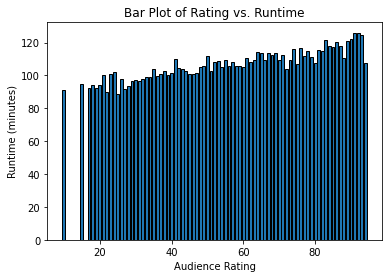

In [18]:
# Create the histogram
plt.bar(average_rating_runtime['audience_rating'], average_rating_runtime['runtime'], edgecolor='black')

# Add labels and title
plt.xlabel('Audience Rating')
plt.ylabel('Runtime (minutes)')
plt.title('Bar Plot of Rating vs. Runtime')

# Show the plot
plt.show()

In [19]:
# Define bins
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90']

# Use pd.cut to bin the data
average_rating_runtime['range_group'] = pd.Series(pd.cut(average_rating_runtime['audience_rating'], bins=bins, labels=labels, right=False))

average_per_bin = average_rating_runtime.groupby('range_group', observed=False)['runtime'].mean()

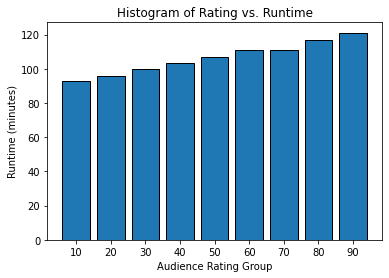

In [20]:
# Create the histogram
plt.bar(average_per_bin.index, average_per_bin, edgecolor='black')

plt.xlabel('Audience Rating Group')
plt.ylabel('Runtime (minutes)')
plt.title('Histogram of Rating vs. Runtime')


# Show the plot
plt.show()

In [21]:
# Get value counts and filter
vc = rr_df['publisher_name'].value_counts()
rows_to_keep = vc[vc >= 1000].index

# Filter the DataFrame
rr_df = rr_df[rr_df['publisher_name'].isin(rows_to_keep)]

In [22]:
def letter_to_number(letter):
    convert = {
        'A+': 1,
        'A': .9,
        'A-': .8,
        'B+': .7,
        'B': .6,
        'B-': .5,
        'C+': .4,
        'C': .3,
        'C-': .2,
        'D+': .1,
        'D': 0,
        'F': 0
    }
    return convert.get(letter, np.nan)


In [23]:

# This function takes a score and converts it to a number
# It can handle letter grades (A, B, C, D, F) and numeric scores
# It can also handle scores in the form of 'x/y' where x and y are numbers
# It returns a numeric score between 0 and 1

def set_fin_score(score):
    if score.startswith(('A', 'B', 'C', 'D', 'F')):
        fin_score = letter_to_number(score)
    else:
        if '/' in score:
            part1, part2 = score.split('/')
            part1 = float(part1)
            part2 = float(part2)
            if part1 == 0 or part2 == 0:
                fin_score = 0
            elif part1 > part2:
                part1 = part1/10
                fin_score = part1 / part2
            else:
                fin_score = part1 / part2
        else:
            if float(score) <=10:
                fin_score = float(score)/10
            else: 
                fin_score = float(score)/100
    return fin_score

In [24]:
# Use the function to convert the review_score column

rr_df['final_score'] = rr_df['review_score'].apply(set_fin_score)

In [25]:
# Group by publisher_name and calculate the average final score
# and sort the results

review_df = rr_df.groupby('publisher_name')['final_score'].mean()
review_df = review_df.reset_index()
review_df = review_df.sort_values(by='final_score', ascending=False)
review_df[0:15]

,publisher_name,final_score
264,Urban Cinefile,0.860000
41,Cinema Sight,0.770198
148,Montreal Film Journal,0.764447
270,Wall Street Journal,0.750000
86,FILMINK (Australia),0.735722
183,Pajiba,0.731579
31,"Capital Times (Madison, WI)",0.728755
128,Kaplan vs. Kaplan,0.726829
52,Combustible Celluloid,0.724296
234,TIME Magazine,0.717391


In [29]:
# Write result2_df to excel for use in Tableau

writer = pd.ExcelWriter('zippedData/tableau.xlsx')
bmrt_df.to_excel(writer, sheet_name='Sheet1')
rr_df.to_excel(writer, sheet_name='Sheet2')
writer.close()

## Results

The results show the "Classics, Comedy, Drama, Romance" genre has the higest gross profit of all genres. The data also shows the top most profitable movies are of the genre "Action & Adventure, Science Fiction & Fantasy"

The highest audience rated movies were about 120 minutes in runtime.

Critics from these publications gave the highest reviews on average:
Cinema Sight, Capital Times (Madison, WI), Combustible Celluloid, and Starburst.